# Prepare your own data
While the SDV offers many publicly available demo datasets, you may want to use one of your own, private datasets for synthetic data creation.

In this notebook, we'll cover the basics of how you can prepare your data for the SDV. This includes loading your data and writing a metadata description of the tables.

_Last Edit: Oct 2, 2024_

# 0. Installation

Install the SDV library.

In [ ]:
%pip install sdv

# Imports

In [21]:
import os, datetime
import pandas as pd
from sdv.metadata import Metadata
from sdv.multi_table import HMASynthesizer

from sdmetrics.visualization import get_column_plot


# 1. Loading the data

In [22]:
# File path to the Excel file
file_path = 'Dataset_2.0_Akkodis.xlsx'

# Import the dataset into a pandas DataFrame
data = pd.read_excel(file_path)

data.columns = data.columns.str.strip()
data['Overall'] = data['Overall'].str.lstrip('~ ') # Makes entries consistent
# data[['City', 'Province', 'Region']] = data['Residence'].str.extract(r'^(.*?) » (.*?) ~ (.*)$')
data['Year of insertion'] = data['Year of insertion'].str.strip('[]') 
data['Year of Recruitment'] = data['Year of Recruitment'].str.strip('[]')

print(data.head)


<bound method NDFrame.head of           ID Candidate State      Age Range  ... Dynamism Mobility English
0      71470           Hired  31 - 35 years  ...      NaN      NaN     NaN
1      71470           Hired  31 - 35 years  ...      NaN      NaN     NaN
2      71470           Hired  31 - 35 years  ...      NaN      NaN     NaN
3      71470           Hired  31 - 35 years  ...      2.0      3.0     3.0
4      71470           Hired  31 - 35 years  ...      NaN      NaN     NaN
...      ...             ...            ...  ...      ...      ...     ...
21372  79993           Hired  26 - 30 years  ...      3.0      3.0     3.0
21373  79993           Hired  26 - 30 years  ...      NaN      NaN     NaN
21374  79993           Hired  26 - 30 years  ...      NaN      NaN     NaN
21375  79993           Hired  26 - 30 years  ...      2.0      3.0     3.0
21376  79993           Hired  26 - 30 years  ...      NaN      NaN     NaN

[21377 rows x 39 columns]>


In [3]:
data['ID'].to_csv('SDV/ID_values.csv', index=False, header=False)

## Data Cleaning

Some IDs are inconsistent, meaning a new entry was made with another contextual variable (Age Range, Sex or Region for instance). Although it could mean that the same candidate has applied again where the contextual variable has changed, it makes sequential analysis a lot harder. Therefore, we will remove the inconsistent rows.

In [23]:
# Columns to exclude (because these will not be contextual inputs)
exclude_columns = [
'ID',
'event_type__val',
'event_feedback',
'linked_search__key',
'Overall',
'Technical Skills',	
'Standing/Position',
'Comunication',	
'Maturity',	
'Dynamism',	
'Mobility',	
'English',
'City',
'Province',
'Region'
]

# Get columns as a list, excluding specific ones
filtered_columns = [col for col in data.columns if col not in exclude_columns]

# List of columns to check for inconsistencies
columns_to_check = filtered_columns

# Check for duplicate IDs where other columns differ
# Group by 'ID' and check for unique values across the specified columns
id_inconsistencies = data.groupby('ID')[columns_to_check].nunique()

# Filter for IDs with inconsistencies (more than one unique value in any critical column)
inconsistent_ids = id_inconsistencies[id_inconsistencies.gt(1).any(axis=1)]

# Sort the dataset by 'ID' and reset the index to ensure sequential appearance
data_sorted = data.sort_values(by=['ID']).reset_index()

# Identify rows belonging to inconsistent IDs
inconsistent_rows = data_sorted['ID'].isin(inconsistent_ids.index)

# Create a mask to keep only the first group of rows for each inconsistent ID
data = data_sorted[~inconsistent_rows | (data_sorted['ID'] != data_sorted['ID'].shift())]

# Drop the index reset during processing
data = data.drop(columns='index')

data = data.reset_index(drop=True)


In [24]:
print(filtered_columns)

['Candidate State', 'Age Range', 'Residence', 'Sex', 'Protected category', 'TAG', 'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role', 'Year of insertion', 'Year of Recruitment', 'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring', 'Job Title Hiring', 'Job Description', 'Candidate Profile', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level', 'Study Area.1', 'Akkodis headquarters', 'Current Ral', 'Expected Ral']


In [21]:
percentages = data.drop_duplicates(subset='ID')['Study Title'].value_counts(normalize=True) * 100
percentages

Study Title
Five-year degree              53.388241
Three-year degree             38.905651
High school graduation         4.077306
master's degree                1.965261
Doctorate                      0.970399
Professional qualification     0.660524
Middle school diploma          0.032618
Name: proportion, dtype: float64

## Creating the dataframes

In [26]:
candidate_columns = filtered_columns.copy()
candidate_columns.append("ID")
print(candidate_columns)


['Candidate State', 'Age Range', 'Residence', 'Sex', 'Protected category', 'TAG', 'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role', 'Year of insertion', 'Year of Recruitment', 'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring', 'Job Title Hiring', 'Job Description', 'Candidate Profile', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level', 'Study Area.1', 'Akkodis headquarters', 'Current Ral', 'Expected Ral', 'ID']


In [ ]:

# Create candidates dataframe
candidates = data[candidate_columns].drop_duplicates(subset='ID')

# Create events dataframe
events = data.drop(columns=[col for col in candidate_columns if col != 'ID']).copy()

# Add 'candidate_id' as foreign key in events
events.rename(columns={'ID': 'candidate_id'}, inplace=True)
events['event_id'] = events.index + 1  # Start event_id from 1

candidates.rename(columns={'ID': 'candidate_id'}, inplace=True)



In [ ]:
#Creating a Dict that maps the pandas dataframes to the table names
real_data = {}
real_data['candidates'] = candidates
real_data['events'] = events

In [28]:
print(events.head)

<bound method NDFrame.head of        candidate_id event_type__val event_feedback  ... Mobility English  event_id
0                15      CV request            NaN  ...      NaN     NaN         1
1                36      CV request            NaN  ...      NaN     NaN         2
2                39      CV request            NaN  ...      NaN     NaN         3
3                41             NaN            NaN  ...      NaN     NaN         4
4                47             NaN            NaN  ...      NaN     NaN         5
...             ...             ...            ...  ...      ...     ...       ...
18704         81626      CV request            NaN  ...      NaN     NaN     18705
18705         81627             NaN            NaN  ...      NaN     NaN     18706
18706         81630    HR interview      OK (live)  ...      1.0     1.0     18707
18707         81636      CV request            NaN  ...      NaN     NaN     18708
18708         81637      CV request            NaN  ...  

# 2. Writing a Metadata Description
The SDV requires that you provide a description of your data, also known as **metadata**.

The metadata describes the types of data that are available in every column.

In [ ]:
metadata = Metadata.detect_from_dataframes(
    data={
        'candidates': candidates,
        'events': events
    })

metadata.update_columns_metadata(
    column_metadata={
        'Technical Skills': { 'sdtype': 'numerical', 'computer_representation': 'Int64' },
        'Standing/Position': { 'sdtype': 'numerical', 'computer_representation': 'Int64' },
        'Comunication': { 'sdtype': 'numerical', 'computer_representation': 'Int64' },
        'Maturity': { 'sdtype': 'numerical', 'computer_representation': 'Int64' },
        'Dynamism': { 'sdtype': 'numerical', 'computer_representation': 'Int64' },
        'Mobility': { 'sdtype': 'numerical', 'computer_representation': 'Int64' },
        'English': { 'sdtype': 'numerical', 'computer_representation': 'Int64' }
    },
    table_name='events',
)
# # Set column ID as primary id stdtype
# metadata.update_column( 
#     column_name='ID',
#     sdtype='id',
#     regex_format='\d{1,5}')

# Set column Candidate State to categorical
metadata.update_column(
    column_name='Candidate State',
    sdtype='categorical')



We can inspect the auto detected metadata:

Auto detected data:



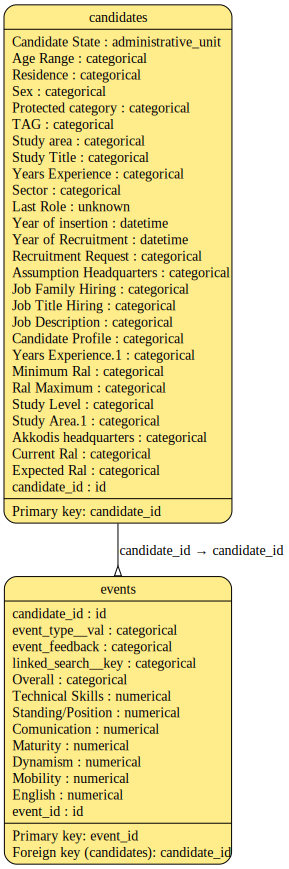

In [35]:
print('Auto detected data:\n')
metadata.visualize()

Creating a subsample of the data for training the model (12k IDs will kill your kernel, Colab tested at 1000 sequences/IDs)

In [7]:
subsampled_data = get_random_sequence_subset(
    data, 
    metadata,
    num_sequences=400
)

## 2.3 Validation
Now, the metadata should be accurate. Let's validate that the metadata format makes sense. If successful, the code below should run without any errors.

In [36]:
metadata.validate()

# 3. Creating Synthetic Data
With these preparatory steps completed, we can now use the metadata description and data in the SDV. The coe below will train a model and create synthetic data.

In [37]:
synthesizer = HMASynthesizer(
    metadata,
    locales='it_IT'
)

/opt/anaconda3/envs/industryproject/lib/python3.11/site-packages/sdv/multi_table/base.py:101: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


### 3.1 Adding constraints

In [ ]:
my_constraint = {
    'constraint_class': 'Inequality',
    'table_name': 'candidates',
    'constraint_parameters': {
        'low_column_name': 'Year of insertion',
        'high_column_name': 'Year of Recruitment',
        'strict_boundaries': False
    }
}

synthesizer.add_constraints(constraints=[
    my_constraint
])

### 3.2 Training the Synthesizer

In [39]:

# Step 2: Train the synthesizer
synthesizer.fit(real_data)


Preprocess Tables: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]



Learning relationships:


(1/1) Tables 'candidates' and 'events' ('candidate_id'): 100%|██████████| 12263/12263 [18:07<00:00, 11.28it/s]


Modeling Tables: 100%|██████████| 2/2 [00:09<00:00,  4.93s/it]


In [42]:

# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(scale=0.0008)


In [43]:
# Extract candidates and events from the synthetic data dictionary
synthetic_candidates = synthetic_data['candidates']
synthetic_events = synthetic_data['events']

# Join the tables on candidate_id and id
# 'left' join ensures all events are preserved
merged_data = synthetic_events.merge(
    synthetic_candidates, 
    on='candidate_id', 
    how='left'
)

# Drop redundant columns if necessary (e.g., the duplicate 'id' column from candidates)
# merged_data = merged_data.drop(columns=['candidate_id'])

# Preview the merged DataFrame
print(merged_data.head())

# Validate row count and column structure
print(f"Number of rows: {len(merged_data)}, Columns: {merged_data.columns.tolist()}")


   candidate_id   event_type__val  ... Current Ral Expected Ral
0       1207108        CV request  ...         NaN          NaN
1       1207108        CV request  ...         NaN          NaN
2      11172921  Notify candidate  ...         NaN      28-30 K
3      11172921  Notify candidate  ...         NaN      28-30 K
4      11725401        CV request  ...         NaN          NaN

[5 rows x 40 columns]
Number of rows: 15, Columns: ['candidate_id', 'event_type__val', 'event_feedback', 'linked_search__key', 'Overall', 'Technical Skills', 'Standing/Position', 'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English', 'event_id', 'Candidate State', 'Age Range', 'Residence', 'Sex', 'Protected category', 'TAG', 'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role', 'Year of insertion', 'Year of Recruitment', 'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring', 'Job Title Hiring', 'Job Description', 'Candidate Profile', 'Years Experience.1', 'Minimum Ra

In [44]:
merged_data.rename(columns={'candidate_id': 'ID'}, inplace=True)
merged_data = merged_data.drop(columns=['event_id'])

order = ['ID', 'Candidate State', 'Age Range', 'Residence', 'Sex',
       'Protected category', 'TAG', 'Study area', 'Study Title',
       'Years Experience', 'Sector', 'Last Role', 'Year of insertion',
       'Year of Recruitment', 'Recruitment Request', 'Assumption Headquarters',
       'Job Family Hiring', 'Job Title Hiring', 'event_type__val',
       'event_feedback', 'linked_search__key', 'Overall', 'Job Description',
       'Candidate Profile', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
       'Study Level', 'Study Area.1', 'Akkodis headquarters', 'Current Ral',
       'Expected Ral', 'Technical Skills', 'Standing/Position', 'Comunication',
       'Maturity', 'Dynamism', 'Mobility', 'English']

merged_data_ordered = merged_data[order]
print(merged_data_ordered.head)

<bound method NDFrame.head of           ID  Candidate State      Age Range  ... Dynamism Mobility English
0    1207108  Pesaro e Urbino  20 - 25 years  ...      NaN      NaN     NaN
1    1207108  Pesaro e Urbino  20 - 25 years  ...      NaN      NaN     NaN
2   11172921          Trieste  20 - 25 years  ...      NaN      NaN     NaN
3   11172921          Trieste  20 - 25 years  ...      1.0      NaN     NaN
4   11725401             Enna  26 - 30 years  ...      NaN      NaN     2.0
5   11725401             Enna  26 - 30 years  ...      NaN      NaN     NaN
6   14204962          Trieste     > 45 years  ...      NaN      1.0     3.0
7   15498172           Savona  26 - 30 years  ...      NaN      NaN     NaN
8   15498172           Savona  26 - 30 years  ...      NaN      1.0     NaN
9   11385807  Reggio Calabria  20 - 25 years  ...      4.0      NaN     4.0
10  10518917          Cremona  26 - 30 years  ...      NaN      1.0     NaN
11  10518917          Cremona  26 - 30 years  ...      1.0

In [45]:
import os, datetime

mydir = os.path.join(os.getcwd(),'SDV/outputs/multitable/', datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(mydir)
print(mydir)

synthesizer.save(filepath=os.path.join(mydir, 'synthesizer.pkl'))

metadata.save_to_json(filepath=os.path.join(mydir,'metadata.json'))

merged_data_ordered.to_csv(os.path.join(mydir, 'synthetic_data.csv'), index=False)

parameters = synthesizer.get_parameters()
with open(os.path.join(mydir, 'parameters.txt'), 'w') as f:
    f.write(str(parameters))


/Users/jarnostijnman/Documents/VS Code/AI Industry project/SDV/outputs/multitable/2024-12-08_20-28-10


## Diagnostics

In [25]:

fig = get_column_plot(
    real_data=data,
    synthetic_data=synthetic_data,
    column_name='Study area'
)

fig.show()

# 4. Biased Sampling

In [ ]:
#Input the number of IDs (aka sequences) that need to have a specific variable, so for instance 50 Males and 50 Females 

scenario_context = pd.DataFrame(data={
    'Sex': ['Male']*50 + ['Female']*50
})

biased_sample = synthesizer.sample_sequential_columns(
    context_columns=scenario_context
)

biased_sample.to_csv('SDV/outputs/biased_sample.csv', index=False)

,Sex
0,Male
1,Male
2,Male
3,Male
4,Male
...,...
95,Female
96,Female
97,Female
98,Female
